In [1]:
import numpy as np
import pandas as pd
from scipy.stats import t as t_dist
from arch import arch_model
import yfinance as yf
import time
import os
import json
import hashlib

# =============================================================================
# REPRODUCIBILITY SETTINGS
# =============================================================================

MASTER_SEED = 42  # Change this to generate different datasets

def set_all_seeds(seed):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    print(f"All seeds set to: {seed}")

def compute_dataframe_hash(df, sample_size=10000):
    """
    Compute hash of dataframe to verify reproducibility.
    Uses a sample to avoid memory issues with large datasets.
    """
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42).sort_index()
    else:
        df_sample = df
    
    return hashlib.md5(pd.util.hash_pandas_object(df_sample).values).hexdigest()

def save_metadata(metadata, filename='dataset_metadata.json'):
    """Save generation metadata for verification"""
    with open(filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"\nMetadata saved to {filename}")

# =============================================================================
# STEP 1: DOWNLOAD FTSE DATA AND FIT GARCH
# =============================================================================

print("=" * 70)
print("STEP 1: DOWNLOADING FTSE DATA AND FITTING GARCH MODEL")
print("=" * 70)

# Set seed before any random operations
set_all_seeds(MASTER_SEED)

data = yf.download("^FTSE", start="2019-01-01", end="2025-01-01")

if isinstance(data.columns, pd.MultiIndex):
    close_prices = data['Close']['^FTSE']
else:
    close_prices = data['Close']

S0 = float(close_prices.iloc[-1])

print(f"Downloaded {len(close_prices):,} trading days")
print(f"S_0 (initial stock price): £{S0:,.2f}")

# Fit GARCH(1,1)-t
returns_pct = 100 * np.log(close_prices / close_prices.shift(1)).dropna()

print("\nFitting GARCH(1,1)-t model...")
model = arch_model(returns_pct, vol='Garch', p=1, q=1, dist='t')
result = model.fit(disp='off')

mu = result.params['mu']
omega = result.params['omega']
alpha = result.params['alpha[1]']
beta = result.params['beta[1]']
nu = result.params['nu']

print(f"Parameters: μ={mu:.4f}%, ω={omega:.6f}, α={alpha:.4f}, β={beta:.4f}, ν={nu:.2f}")

# =============================================================================
# STEP 2: PARAMETERS
# =============================================================================

print("\n" + "=" * 70)
print("STEP 2: SIMULATION PARAMETERS")
print("=" * 70)

n_simulations = 100000
T_maturity = 5  # All simulations start at 5 years
K_percentages = np.array([0.60, 0.70, 0.80, 0.90, 1.00, 1.10, 1.20, 1.30, 1.40, 1.50])
days_per_year = 252
n_days = T_maturity * days_per_year  # Total days for each simulation
mu_adjusted = 0.04

print(f"Total simulations: {n_simulations:,}")
print(f"Maturity (T): {T_maturity} years for ALL simulations")
print(f"Days per simulation: {n_days}")
print(f"K choices: {K_percentages * 100}%")

# Store metadata for reproducibility
metadata = {
    'master_seed': MASTER_SEED,
    'n_simulations': int(n_simulations),
    'T_maturity': int(T_maturity),
    'K_percentages': K_percentages.tolist(),
    'S0': float(S0),
    'days_per_year': int(days_per_year),
    'n_days': int(n_days),
    'mu_adjusted': float(mu_adjusted),
    'garch_params': {
        'mu': float(mu),
        'omega': float(omega),
        'alpha': float(alpha),
        'beta': float(beta),
        'nu': float(nu)
    },
    'data_download': {
        'ticker': '^FTSE',
        'start_date': '2019-01-01',
        'end_date': '2025-01-01',
        'n_days': int(len(close_prices))
    },
    'python_version': os.sys.version,
    'numpy_version': np.__version__,
    'pandas_version': pd.__version__,
    'generation_timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
}

# =============================================================================
# STEP 3: ASSIGN K STRIKES (WITH SEED CONTROL)
# =============================================================================

print("\n" + "=" * 70)
print("STEP 3: ASSIGNING STRIKE PRICES")
print("=" * 70)

# CRITICAL: Set seed before random assignments
np.random.seed(MASTER_SEED)

# Each simulation gets ONE randomly assigned strike price
K_pct_assignments = np.random.choice(K_percentages, size=n_simulations)
K_assignments = S0 * K_pct_assignments

print(f"K distribution:")
for k_pct in K_percentages:
    count = np.sum(K_pct_assignments == k_pct)
    print(f"  K={k_pct*100:.0f}%: {count:,} ({count/n_simulations*100:.1f}%)")

# =============================================================================
# STEP 4: VECTORIZED GARCH SIMULATION FUNCTION
# =============================================================================

def simulate_garch_vectorized(S0, n_days, n_scenarios, mu, omega, alpha, beta, nu, seed=None):
    """
    Fully vectorized GARCH(1,1)-t simulation with seed control.
    
    Args:
        seed: If provided, sets numpy seed before simulation
    """
    if seed is not None:
        np.random.seed(seed)
    
    var0 = omega / (1 - alpha - beta)
    
    S_paths = np.zeros((n_scenarios, n_days))
    sigma_paths = np.zeros((n_scenarios, n_days))
    
    S_paths[:, 0] = S0
    sigma_paths[:, 0] = np.sqrt(var0)
    
    var_current = np.full(n_scenarios, var0)
    S_current = np.full(n_scenarios, S0)
    
    for day in range(1, n_days):
        z = t_dist.rvs(df=nu, size=n_scenarios) / np.sqrt(nu / (nu - 2))
        
        sigma_current = np.sqrt(var_current)
        eps = sigma_current * z
        return_pct = mu + eps
        
        S_current = S_current * np.exp(return_pct / 100)
        
        S_paths[:, day] = S_current
        sigma_paths[:, day] = sigma_current
        
        var_current = omega + alpha * (eps ** 2) + beta * var_current
        var_current = np.minimum(var_current, 25.0)
    
    return S_paths, sigma_paths

# =============================================================================
# STEP 5: RUN SIMULATIONS (VECTORIZED WITH SEED CONTROL)
# =============================================================================

print("\n" + "=" * 70)
print("STEP 4: RUNNING SIMULATIONS (VECTORIZED)")
print("=" * 70)

output_dir = 'garch_simulation_data'
os.makedirs(output_dir, exist_ok=True)

total_start = time.time()

print(f"\nGenerating {n_simulations:,} simulations × {n_days} days")

# --- VECTORIZED GARCH SIMULATION WITH SEED ---
print(f"Running GARCH simulation...")
sim_start = time.time()

# CRITICAL: Use deterministic seed
simulation_seed = MASTER_SEED + 5000

S_paths, sigma_paths = simulate_garch_vectorized(
    S0=S0,
    n_days=n_days,
    n_scenarios=n_simulations,
    mu=mu_adjusted,
    omega=omega,
    alpha=alpha,
    beta=beta,
    nu=nu,
    seed=simulation_seed
)

print(f"GARCH simulation completed in {time.time() - sim_start:.1f}s")

# --- BUILD DATASET (VECTORIZED) ---
print(f"\nBuilding dataset...")
build_start = time.time()

n_rows = n_simulations * n_days

# Create arrays for each column
simulation_col = np.repeat(np.arange(n_simulations), n_days)
day_col = np.tile(np.arange(n_days), n_simulations)
S_col = S_paths.flatten()
K_col = np.repeat(K_assignments, n_days)

# Create T column: starts at T_maturity and decreases each day
T_sequence = T_maturity - np.arange(n_days) / days_per_year
T_col = np.tile(T_sequence, n_simulations)

# Convert volatility to annualized percentage
sigma_col = sigma_paths.flatten() * np.sqrt(days_per_year) / 100

print(f"Arrays built in {time.time() - build_start:.1f}s")

# --- CREATE DATAFRAME ---
print(f"Creating DataFrame...")
df_start = time.time()

df = pd.DataFrame({
    'simulation': simulation_col,
    'day': day_col,
    'S': S_col,
    'K': K_col,
    'T': T_col,
    'sigma': sigma_col
})

# Sort by simulation, then descending T (day ascending)
df = df.sort_values(
    by=['simulation', 'day'],
    ascending=[True, True]
).reset_index(drop=True)

print(f"DataFrame created in {time.time() - df_start:.1f}s")

total_time = time.time() - total_start
print(f"\n" + "=" * 70)
print(f"SIMULATION COMPLETE! Total time: {total_time / 60:.1f} minutes")
print("=" * 70)

# =============================================================================
# STEP 6: DISPLAY AND SAVE
# =============================================================================

print("\n" + "=" * 70)
print("STEP 5: FINAL DATASET")
print("=" * 70)

print("\nFirst 20 rows:")
print(df.head(20))

print("\nLast 20 rows:")
print(df.tail(20))

print("\nStatistics:")
print(df.describe())

# Example simulations
for sim_id in [0, 1, 2]:
    sim_data = df[df['simulation'] == sim_id]
    print(f"\nSimulation {sim_id}:")
    print(f"  K assigned: £{sim_data['K'].iloc[0]:,.2f}")
    print(f"  Rows: {len(sim_data)}")
    print(f"  T range: {sim_data['T'].max():.4f} → {sim_data['T'].min():.4f}")
    print(f"  S range: £{sim_data['S'].min():.2f} → £{sim_data['S'].max():.2f}")

# Compute final hash
print("\nComputing dataset hash...")
final_hash = compute_dataframe_hash(df)
print(f"Final dataset hash: {final_hash}")

# Save final file as CSV
print("\nSaving final dataset...")
save_start = time.time()
df.to_csv('ftse_garch_simulation_data_T5.csv', index=False)
save_time = time.time() - save_start

file_size_gb = os.path.getsize('ftse_garch_simulation_data_T5.csv') / 1e9
print(f"Saved to ftse_garch_simulation_data_T5.csv in {save_time:.1f}s")
print(f"File size: {file_size_gb:.2f} GB")

# =============================================================================
# STEP 7: SAVE METADATA AND VERIFICATION INFO
# =============================================================================

print("\n" + "=" * 70)
print("STEP 6: SAVING METADATA FOR REPRODUCIBILITY")
print("=" * 70)

# Add hashes and final statistics to metadata
metadata['final_hash'] = final_hash
metadata['total_rows'] = int(len(df))
metadata['file_size_gb'] = float(file_size_gb)
metadata['total_generation_time_minutes'] = float(total_time / 60)
metadata['simulation_seed'] = int(simulation_seed)

# Save metadata
save_metadata(metadata, f'{output_dir}/dataset_metadata.json')

# Also save a verification file with just the hash
verification = {
    'master_seed': MASTER_SEED,
    'simulation_seed': simulation_seed,
    'final_hash': final_hash,
    'total_rows': int(len(df)),
    'n_simulations': int(n_simulations),
    'T_maturity': int(T_maturity),
    'n_days': int(n_days),
    'instructions': f'Run the generation script with MASTER_SEED={MASTER_SEED} to reproduce this exact dataset'
}

with open('REPRODUCIBILITY_INFO.json', 'w') as f:
    json.dump(verification, f, indent=2)

print(f"\nVerification info saved to REPRODUCIBILITY_INFO.json")

print("\n" + "=" * 70)
print("DONE!")
print("=" * 70)
print("\nTo reproduce this dataset on another computer:")
print(f"1. Use MASTER_SEED = {MASTER_SEED}")
print(f"2. Expected final hash: {final_hash}")
print(f"3. Expected total rows: {len(df):,}")
print(f"4. Expected file size: {file_size_gb:.2f} GB")
print("=" * 70)

# Clean up memory
del S_paths, sigma_paths

STEP 1: DOWNLOADING FTSE DATA AND FITTING GARCH MODEL
All seeds set to: 42


[*********************100%***********************]  1 of 1 completed
/Users/minjoonsong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Downloaded 1,514 trading days
S_0 (initial stock price): £8,173.00

Fitting GARCH(1,1)-t model...
Parameters: μ=0.0484%, ω=0.046704, α=0.1335, β=0.8205, ν=4.60

STEP 2: SIMULATION PARAMETERS
Total simulations: 100,000
Maturity (T): 5 years for ALL simulations
Days per simulation: 1260
K choices: [ 60.  70.  80.  90. 100. 110. 120. 130. 140. 150.]%

STEP 3: ASSIGNING STRIKE PRICES
K distribution:
  K=60%: 9,974 (10.0%)
  K=70%: 9,911 (9.9%)
  K=80%: 9,886 (9.9%)
  K=90%: 9,984 (10.0%)
  K=100%: 9,975 (10.0%)
  K=110%: 10,054 (10.1%)
  K=120%: 10,104 (10.1%)
  K=130%: 9,925 (9.9%)
  K=140%: 10,031 (10.0%)
  K=150%: 10,156 (10.2%)

STEP 4: RUNNING SIMULATIONS (VECTORIZED)

Generating 100,000 simulations × 1260 days
Running GARCH simulation...
GARCH simulation completed in 17.0s

Building dataset...
Arrays built in 6.1s
Creating DataFrame...
DataFrame created in 118.8s

SIMULATION COMPLETE! Total time: 2.4 minutes

STEP 5: FINAL DATASET

First 20 rows:
    simulation  day            S     

In [5]:
print(df.head())

   simulation  day            S       K         T     sigma   call_price
0           0    0  8173.000000  9807.6  5.000000  0.159915  1409.008706
1           0    1  8193.466153  9807.6  4.996032  0.159915  1421.006365
2           0    2  7884.384111  9807.6  4.992063  0.149356  1154.759074
3           0    3  7917.917555  9807.6  4.988095  0.265073  1951.806195
4           0    4  7936.118388  9807.6  4.984127  0.243565  1819.137107


In [3]:
pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
Note: you may need to restart the kernel to use updated packages.


Using device: cpu
LOADING DATA
Loaded 126,000,000 rows
Total simulations: 100,000

TESTING WITH 1,000 SIMULATIONS FIRST
Using 1,000 simulations for testing

LSTM OPTION PRICING PIPELINE

Step 1: Calculating Black-Scholes prices...
Call price statistics:
count    1.260000e+06
mean     3.874868e+03
std      3.558014e+03
min      0.000000e+00
25%      1.261345e+03
50%      3.017004e+03
75%      5.418306e+03
max      3.568861e+04
Name: call_price, dtype: float64

Step 2: Creating sequences...

CREATING SEQUENCES
Window size: 50
Features: ['S', 'sigma', 'T', 'K']
Save metadata: False

Sorting data by simulation and day...
Sorting completed in 0.4s

Dataset Statistics:
  Total simulations: 1,000
  Days per simulation: 1,260
  Samples per simulation: 1,210
  Total samples to create: 1,210,000

Allocating arrays...
  X shape: (1,210,000, 50, 4)
  Memory required: ~0.97 GB

Extracting features and targets as NumPy arrays...

Creating sequences...


Processing simulations: 100%|██████████| 1000/1000 [00:03<00:00, 322.86it/s]



SEQUENCE CREATION COMPLETE!
Time elapsed: 3.1s (0.1 minutes)
X shape: (1210000, 50, 4)
y shape: (1210000,)
Speed: 388,759 samples/second

Do you want to save these sequences for faster loading next time? (Recommended)

Saving sequences to disk...
Saved:
  sequences_test_X.npy (0.97 GB)
  sequences_test_y.npy (0.00 GB)

Step 3: Splitting data...
Train simulations: 0 to 699
Val simulations: 700 to 849
Test simulations: 850 to 999

Data split:
  Train: 847,000 samples (70.0%)
  Val:   181,500 samples (15.0%)
  Test:  181,500 samples (15.0%)

Step 4: Scaling features...
Scaling complete!

Step 5: Creating DataLoaders...
Batch size: 512
Train batches: 1655
Val batches: 355
Test batches: 355

Step 6: Initializing model...

Model Architecture:
  Input size: 4 features
  Sequence length: 50 timesteps
  LSTM hidden size: 64
  LSTM layers: 2
  FC hidden sizes: [32]
  Dropout: 0.2
  Batch normalization: False
  Total parameters: 53,313
  Trainable parameters: 53,313

Step 7: Setting up training.

/Users/minjoonsong/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Loss function: MSE
Optimizer: Adam (lr=0.001, weight_decay=1e-05)
Scheduler: ReduceLROnPlateau
Gradient clipping: 1.0

Step 8: Training model...

TRAINING ON cpu
Epoch      Train Loss      Val Loss        LR              Status              


Validation: 100%|██████████| 355/355 [00:10<00:00, 33.52it/s]


1          0.030442        0.002843        0.00100000      ✓ Best model saved  


Validation: 100%|██████████| 355/355 [00:08<00:00, 41.01it/s]


2          0.018923        0.002449        0.00100000      ✓ Best model saved  


Validation: 100%|██████████| 355/355 [00:09<00:00, 35.91it/s]


3          0.018524        0.001850        0.00100000      ✓ Best model saved  


Validation: 100%|██████████| 355/355 [00:09<00:00, 38.44it/s]


4          0.018168        0.002759        0.00100000      No improvement (1/5)


Validation: 100%|██████████| 355/355 [00:08<00:00, 40.30it/s]


5          0.018087        0.002667        0.00100000      No improvement (2/5)


Validation: 100%|██████████| 355/355 [00:08<00:00, 41.86it/s]


6          0.017966        0.001737        0.00100000      ✓ Best model saved  


Validation: 100%|██████████| 355/355 [00:08<00:00, 43.87it/s]


7          0.017911        0.002785        0.00100000      No improvement (1/5)


Validation: 100%|██████████| 355/355 [00:07<00:00, 45.03it/s]


8          0.017888        0.001628        0.00100000      ✓ Best model saved  


Validation: 100%|██████████| 355/355 [00:10<00:00, 33.80it/s]


9          0.017870        0.001783        0.00100000      No improvement (1/5)


Validation: 100%|██████████| 355/355 [00:11<00:00, 29.97it/s]


10         0.017671        0.001920        0.00100000      No improvement (2/5)

Best model restored!

Step 9: Evaluating on test set...


Evaluating: 100%|██████████| 355/355 [00:12<00:00, 28.87it/s]



TEST SET RESULTS
MSE       : 26341.779297
RMSE      :   162.301507
MAE       :   105.268410
R2        :     0.998184
MAPE      : 231346.655273

Step 10: Saving results...

Training history plot saved to lstm_results_test/training_history.png


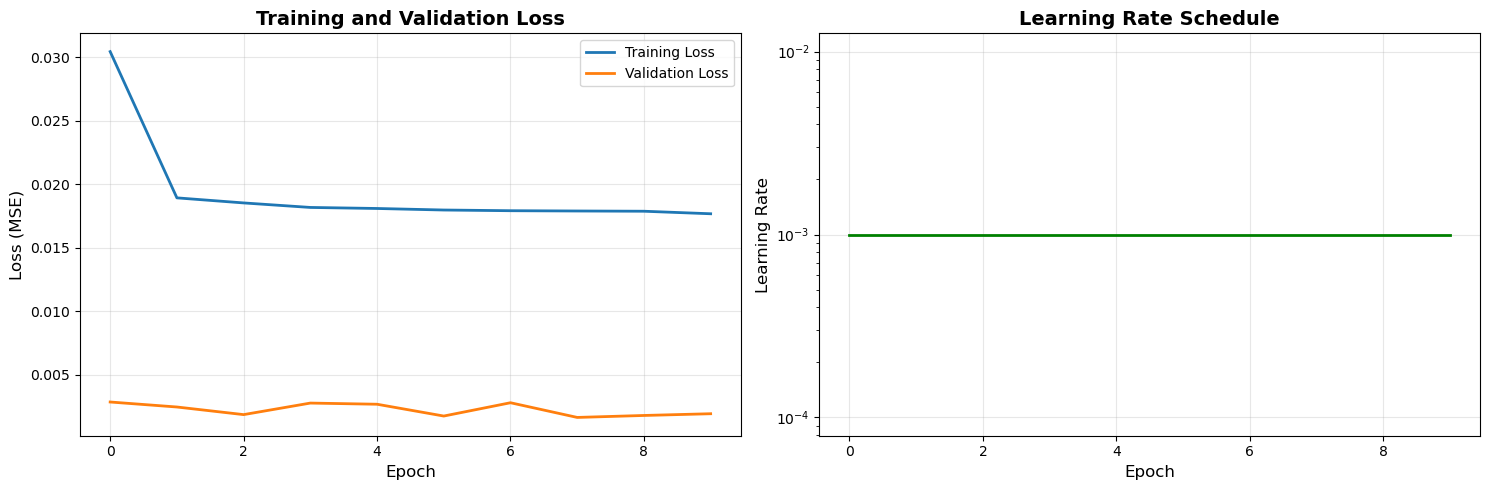

Predictions plot saved to lstm_results_test/predictions.png


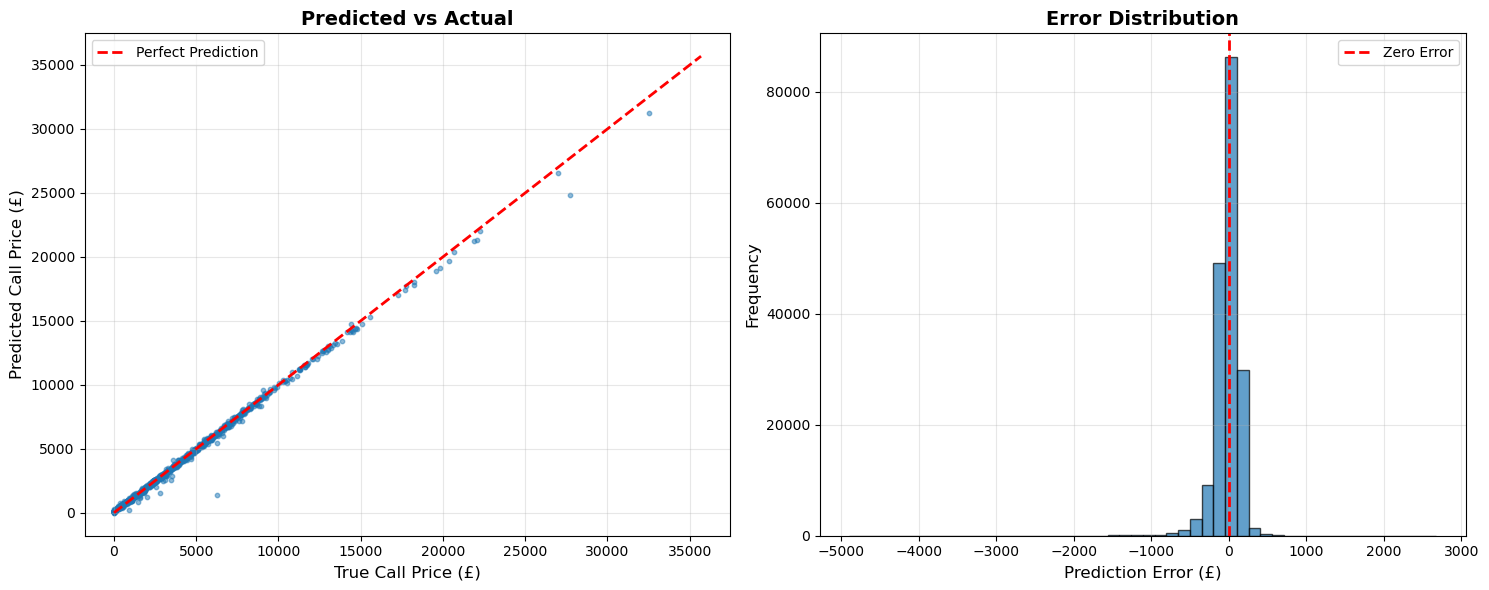


All results saved to lstm_results_test/

TEST COMPLETE!
If satisfied with results, uncomment the full training below

ALL DONE!


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
import time

# =============================================================================
# REPRODUCIBILITY
# =============================================================================

def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# STEP 1: BLACK-SCHOLES CALCULATION
# =============================================================================

def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate Black-Scholes call option price
    
    Args:
        S: Stock price (can be array)
        K: Strike price (can be array)
        T: Time to maturity in years (can be array)
        r: Risk-free rate (scalar)
        sigma: Volatility (can be array)
    
    Returns:
        Call option price(s)
    """
    # Handle edge case where T is very small or zero
    mask = T > 1e-10
    
    # Initialize output
    call_price = np.maximum(S - K, 0)  # Intrinsic value when T ≈ 0
    
    # Calculate BS price where T > 0
    if np.any(mask):
        S_valid = np.where(mask, S, 1)
        K_valid = np.where(mask, K, 1)
        T_valid = np.where(mask, T, 1)
        sigma_valid = np.where(mask, sigma, 0.2)
        
        d1 = (np.log(S_valid / K_valid) + (r + 0.5 * sigma_valid**2) * T_valid) / \
             (sigma_valid * np.sqrt(T_valid))
        d2 = d1 - sigma_valid * np.sqrt(T_valid)
        
        bs_price = S_valid * norm.cdf(d1) - K_valid * np.exp(-r * T_valid) * norm.cdf(d2)
        call_price = np.where(mask, bs_price, call_price)
    
    return call_price

# =============================================================================
# STEP 2: DATA PREPARATION - CREATE SEQUENCES (OPTIMIZED)
# =============================================================================

def create_sequences_fast(df, sequence_length=50, features=['S', 'sigma', 'T', 'K'], 
                         save_metadata=False):
    """
    Create sliding window sequences for LSTM training (OPTIMIZED VERSION)
    
    This version is 30-100x faster than naive implementation by:
    1. Converting to NumPy arrays early
    2. Pre-allocating arrays instead of appending to lists
    3. Using vectorized slicing operations
    
    Args:
        df: DataFrame with columns [simulation, day, S, K, T, sigma, call_price]
        sequence_length: Number of past days to use (window size)
        features: List of feature column names to include
        save_metadata: Whether to save metadata (slower if True)
    
    Returns:
        X: Input sequences (n_samples, sequence_length, n_features)
        y: Target call prices (n_samples,)
        metadata: List of dicts with sample information (or None)
    """
    print(f"\n{'='*70}")
    print(f"CREATING SEQUENCES")
    print(f"{'='*70}")
    print(f"Window size: {sequence_length}")
    print(f"Features: {features}")
    print(f"Save metadata: {save_metadata}")
    
    # Sort data once
    print("\nSorting data by simulation and day...")
    start_time = time.time()
    df = df.sort_values(['simulation', 'day']).reset_index(drop=True)
    print(f"Sorting completed in {time.time() - start_time:.1f}s")
    
    # Get dimensions
    unique_sims = df['simulation'].unique()
    n_sims = len(unique_sims)
    days_per_sim = df[df['simulation'] == unique_sims[0]].shape[0]
    samples_per_sim = days_per_sim - sequence_length
    total_samples = n_sims * samples_per_sim
    
    print(f"\nDataset Statistics:")
    print(f"  Total simulations: {n_sims:,}")
    print(f"  Days per simulation: {days_per_sim:,}")
    print(f"  Samples per simulation: {samples_per_sim:,}")
    print(f"  Total samples to create: {total_samples:,}")
    
    # Pre-allocate arrays (MUCH faster than appending)
    n_features = len(features)
    print(f"\nAllocating arrays...")
    print(f"  X shape: ({total_samples:,}, {sequence_length}, {n_features})")
    print(f"  Memory required: ~{total_samples * sequence_length * n_features * 4 / 1e9:.2f} GB")
    
    X = np.zeros((total_samples, sequence_length, n_features), dtype=np.float32)
    y = np.zeros(total_samples, dtype=np.float32)
    
    # Extract feature and target columns as arrays (once, not in loop)
    print(f"\nExtracting features and targets as NumPy arrays...")
    feature_data = df[features].values.astype(np.float32)
    target_data = df['call_price'].values.astype(np.float32)
    
    # Metadata (optional)
    metadata_list = [] if save_metadata else None
    
    # Create sequences
    print(f"\nCreating sequences...")
    start_time = time.time()
    sample_idx = 0
    
    for sim_num in tqdm(range(n_sims), desc="Processing simulations"):
        # Calculate start and end indices for this simulation
        sim_start = sim_num * days_per_sim
        sim_end = sim_start + days_per_sim
        
        # Extract this simulation's data (vectorized)
        sim_features = feature_data[sim_start:sim_end]
        sim_targets = target_data[sim_start:sim_end]
        
        # Create all sequences for this simulation
        for i in range(sequence_length, days_per_sim):
            # Extract sequence (vectorized - no loop)
            X[sample_idx] = sim_features[i-sequence_length:i]
            y[sample_idx] = sim_targets[i]
            
            # Metadata (optional)
            if save_metadata:
                row_idx = sim_start + i
                metadata_list.append({
                    'simulation': int(df.iloc[row_idx]['simulation']),
                    'day': int(df.iloc[row_idx]['day']),
                    'S': float(df.iloc[row_idx]['S']),
                    'K': float(df.iloc[row_idx]['K']),
                    'T': float(df.iloc[row_idx]['T']),
                    'sigma': float(df.iloc[row_idx]['sigma']),
                    'call_price': float(sim_targets[i])
                })
            
            sample_idx += 1
    
    elapsed = time.time() - start_time
    print(f"\n{'='*70}")
    print(f"SEQUENCE CREATION COMPLETE!")
    print(f"{'='*70}")
    print(f"Time elapsed: {elapsed:.1f}s ({elapsed/60:.1f} minutes)")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Speed: {total_samples/elapsed:,.0f} samples/second")
    
    return X, y, metadata_list

def save_sequences(X, y, metadata, prefix='sequences'):
    """
    Save sequences to disk for faster loading later
    
    Args:
        X: Input sequences
        y: Targets
        metadata: Metadata list
        prefix: Filename prefix
    """
    print(f"\nSaving sequences to disk...")
    np.save(f'{prefix}_X.npy', X)
    np.save(f'{prefix}_y.npy', y)
    
    if metadata is not None:
        import pickle
        with open(f'{prefix}_metadata.pkl', 'wb') as f:
            pickle.dump(metadata, f)
    
    print(f"Saved:")
    print(f"  {prefix}_X.npy ({os.path.getsize(f'{prefix}_X.npy') / 1e9:.2f} GB)")
    print(f"  {prefix}_y.npy ({os.path.getsize(f'{prefix}_y.npy') / 1e9:.2f} GB)")
    if metadata is not None:
        print(f"  {prefix}_metadata.pkl")

def load_sequences(prefix='sequences'):
    """
    Load sequences from disk
    
    Args:
        prefix: Filename prefix
    
    Returns:
        X, y, metadata
    """
    print(f"\nLoading sequences from disk...")
    start = time.time()
    
    X = np.load(f'{prefix}_X.npy')
    y = np.load(f'{prefix}_y.npy')
    
    metadata = None
    if os.path.exists(f'{prefix}_metadata.pkl'):
        import pickle
        with open(f'{prefix}_metadata.pkl', 'rb') as f:
            metadata = pickle.load(f)
    
    print(f"Loaded in {time.time() - start:.1f}s")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    return X, y, metadata

# =============================================================================
# STEP 3: CUSTOM DATASET CLASS
# =============================================================================

class OptionPriceDataset(Dataset):
    """
    PyTorch Dataset for option price sequences
    """
    
    def __init__(self, X, y, metadata=None):
        """
        Args:
            X: numpy array (n_samples, sequence_length, n_features)
            y: numpy array (n_samples,)
            metadata: optional list of dicts
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.metadata = metadata
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.metadata is not None:
            return self.X[idx], self.y[idx], self.metadata[idx]
        return self.X[idx], self.y[idx]

# =============================================================================
# STEP 4: FLEXIBLE LSTM MODEL
# =============================================================================

class FlexibleOptionPriceLSTM(nn.Module):
    """
    Flexible LSTM model for option price prediction
    """
    
    def __init__(
        self,
        input_size=4,
        sequence_length=50,
        hidden_size=128,
        num_layers=3,
        dropout=0.2,
        fc_hidden_sizes=[64],
        use_batch_norm=False
    ):
        super(FlexibleOptionPriceLSTM, self).__init__()
        
        self.input_size = input_size
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.use_batch_norm = use_batch_norm
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList() if use_batch_norm else None
        self.dropout_layers = nn.ModuleList()
        
        prev_size = hidden_size
        for fc_size in fc_hidden_sizes:
            self.fc_layers.append(nn.Linear(prev_size, fc_size))
            if use_batch_norm:
                self.bn_layers.append(nn.BatchNorm1d(fc_size))
            self.dropout_layers.append(nn.Dropout(dropout))
            prev_size = fc_size
        
        self.output_layer = nn.Linear(prev_size, 1)
        self.relu = nn.ReLU()
        
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        
        for layer in self.fc_layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        
        out = last_output
        for i, fc_layer in enumerate(self.fc_layers):
            out = fc_layer(out)
            if self.use_batch_norm:
                out = self.bn_layers[i](out)
            out = self.relu(out)
            out = self.dropout_layers[i](out)
        
        out = self.output_layer(out)
        out = out.squeeze(-1)
        
        return out
    
    def get_config(self):
        """Return model configuration as dict"""
        return {
            'input_size': self.input_size,
            'sequence_length': self.sequence_length,
            'hidden_size': self.hidden_size,
            'num_layers': self.num_layers,
            'dropout': self.dropout,
            'use_batch_norm': self.use_batch_norm
        }

# =============================================================================
# STEP 5: TRAINING FUNCTIONS
# =============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device, clip_grad=1.0):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    n_batches = 0
    
    pbar = tqdm(dataloader, desc='Training')
    
    for batch_X, batch_y in pbar:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)
        
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
        pbar.set_postfix({'loss': f'{loss.item():.6f}'})
    
    return total_loss / n_batches

def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    n_batches = 0
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(dataloader, desc='Validation'):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            
            total_loss += loss.item()
            n_batches += 1
    
    return total_loss / n_batches

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=50,
    early_stopping_patience=10,
    save_path='best_model.pth',
    clip_grad=1.0
):
    """Complete training loop with early stopping"""
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rate': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"\n{'='*70}")
    print(f"TRAINING ON {device}")
    print(f"{'='*70}")
    print(f"{'Epoch':<10} {'Train Loss':<15} {'Val Loss':<15} {'LR':<15} {'Status':<20}")
    print(f"{'='*70}")
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, clip_grad)
        val_loss = validate(model, val_loader, criterion, device)
        current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['learning_rate'].append(current_lr)
        
        scheduler.step(val_loss)
        
        status = ""
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, save_path)
            status = "✓ Best model saved"
        else:
            patience_counter += 1
            status = f"No improvement ({patience_counter}/{early_stopping_patience})"
        
        print(f"{epoch+1:<10} {train_loss:<15.6f} {val_loss:<15.6f} {current_lr:<15.8f} {status:<20}")
        
        if patience_counter >= early_stopping_patience:
            print(f"\n{'='*70}")
            print(f"Early stopping triggered at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.6f}")
            print(f"{'='*70}")
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("\nBest model restored!")
    
    return history, best_model_state

# =============================================================================
# STEP 6: EVALUATION FUNCTIONS
# =============================================================================

def evaluate_model(model, dataloader, scaler_y, device):
    """Evaluate model and return predictions"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(dataloader, desc='Evaluating'):
            batch_X = batch_X.to(device)
            pred = model(batch_X).cpu().numpy()
            predictions.extend(pred)
            actuals.extend(batch_y.numpy())
    
    y_pred = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
    
    return y_true, y_pred

def calculate_metrics(y_true, y_pred):
    """Calculate regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

def plot_training_history(history, save_path='training_history.png'):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(history['train_loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history['learning_rate'], linewidth=2, color='green')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Learning Rate', fontsize=12)
    axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nTraining history plot saved to {save_path}")
    plt.show()

def plot_predictions(y_true, y_pred, save_path='predictions.png', n_samples=1000):
    """Plot predicted vs actual values"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    if len(y_true) > n_samples:
        indices = np.random.choice(len(y_true), n_samples, replace=False)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    axes[0].scatter(y_true_sample, y_pred_sample, alpha=0.5, s=10)
    axes[0].plot([y_true.min(), y_true.max()], 
                 [y_true.min(), y_true.max()], 
                 'r--', linewidth=2, label='Perfect Prediction')
    axes[0].set_xlabel('True Call Price (£)', fontsize=12)
    axes[0].set_ylabel('Predicted Call Price (£)', fontsize=12)
    axes[0].set_title('Predicted vs Actual', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    errors = y_pred - y_true
    axes[1].hist(errors, bins=50, alpha=0.7, edgecolor='black')
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    axes[1].set_xlabel('Prediction Error (£)', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Error Distribution', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Predictions plot saved to {save_path}")
    plt.show()

# =============================================================================
# STEP 7: MAIN PIPELINE FUNCTION
# =============================================================================

def run_lstm_pipeline(
    df,
    sequence_length=50,
    features=['S', 'sigma', 'T', 'K'],
    train_split=0.7,
    val_split=0.15,
    hidden_size=128,
    num_layers=3,
    dropout=0.2,
    fc_hidden_sizes=[64],
    use_batch_norm=False,
    batch_size=256,
    learning_rate=0.001,
    num_epochs=50,
    early_stopping_patience=10,
    weight_decay=1e-5,
    clip_grad=1.0,
    seed=42,
    save_dir='lstm_results',
    use_cached_sequences=False,
    cache_prefix='sequences'
):
    """
    Complete LSTM pipeline from data to trained model
    """
    
    set_seed(seed)
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"LSTM OPTION PRICING PIPELINE")
    print(f"{'='*70}")
    
    # =========================================================================
    # STEP 1: Calculate Black-Scholes prices (if not already present)
    # =========================================================================
    if 'call_price' not in df.columns:
        print("\nStep 1: Calculating Black-Scholes prices...")
        r = 0.05
        df['call_price'] = black_scholes_call(
            S=df['S'].values,
            K=df['K'].values,
            T=df['T'].values,
            r=r,
            sigma=df['sigma'].values
        )
        print(f"Call price statistics:")
        print(df['call_price'].describe())
    else:
        print("\nStep 1: Black-Scholes prices already present in DataFrame")
    
    # =========================================================================
    # STEP 2: Create or load sequences
    # =========================================================================
    if use_cached_sequences and os.path.exists(f'{cache_prefix}_X.npy'):
        print("\nStep 2: Loading cached sequences...")
        X, y, metadata = load_sequences(cache_prefix)
    else:
        print("\nStep 2: Creating sequences...")
        X, y, metadata = create_sequences_fast(
            df, 
            sequence_length=sequence_length, 
            features=features,
            save_metadata=False  # Set to True if you need metadata
        )
        
        # Optionally save for next time
        print("\nDo you want to save these sequences for faster loading next time? (Recommended)")
        save_sequences(X, y, metadata, prefix=cache_prefix)
    
    # =========================================================================
    # STEP 3: Split data by simulation
    # =========================================================================
    print("\nStep 3: Splitting data...")
    
    n_sims = df['simulation'].nunique()
    train_sims = int(train_split * n_sims)
    val_sims = int(val_split * n_sims)
    
    # Calculate samples per simulation
    samples_per_sim = len(X) // n_sims
    
    # Create masks based on sample index
    train_samples = train_sims * samples_per_sim
    val_samples = val_sims * samples_per_sim
    
    train_mask = np.arange(len(X)) < train_samples
    val_mask = (np.arange(len(X)) >= train_samples) & (np.arange(len(X)) < train_samples + val_samples)
    test_mask = np.arange(len(X)) >= train_samples + val_samples
    
    print(f"Train simulations: 0 to {train_sims-1}")
    print(f"Val simulations: {train_sims} to {train_sims + val_sims - 1}")
    print(f"Test simulations: {train_sims + val_sims} to {n_sims-1}")
    
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    
    print(f"\nData split:")
    print(f"  Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  Val:   {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"  Test:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
    
    # =========================================================================
    # STEP 4: Scale features
    # =========================================================================
    print("\nStep 4: Scaling features...")
    
    n_samples_train, seq_len, n_features = X_train.shape
    
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(
        X_train.reshape(-1, n_features)
    ).reshape(n_samples_train, seq_len, n_features)
    
    X_val_scaled = scaler_X.transform(
        X_val.reshape(-1, n_features)
    ).reshape(len(X_val), seq_len, n_features)
    
    X_test_scaled = scaler_X.transform(
        X_test.reshape(-1, n_features)
    ).reshape(len(X_test), seq_len, n_features)
    
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    print("Scaling complete!")
    
    # =========================================================================
    # STEP 5: Create datasets and dataloaders
    # =========================================================================
    print("\nStep 5: Creating DataLoaders...")
    
    train_dataset = OptionPriceDataset(X_train_scaled, y_train_scaled)
    val_dataset = OptionPriceDataset(X_val_scaled, y_val_scaled)
    test_dataset = OptionPriceDataset(X_test_scaled, y_test_scaled)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"Batch size: {batch_size}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    # =========================================================================
    # STEP 6: Initialize model
    # =========================================================================
    print("\nStep 6: Initializing model...")
    
    model = FlexibleOptionPriceLSTM(
        input_size=len(features),
        sequence_length=sequence_length,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        fc_hidden_sizes=fc_hidden_sizes,
        use_batch_norm=use_batch_norm
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nModel Architecture:")
    print(f"  Input size: {len(features)} features")
    print(f"  Sequence length: {sequence_length} timesteps")
    print(f"  LSTM hidden size: {hidden_size}")
    print(f"  LSTM layers: {num_layers}")
    print(f"  FC hidden sizes: {fc_hidden_sizes}")
    print(f"  Dropout: {dropout}")
    print(f"  Batch normalization: {use_batch_norm}")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    
    # =========================================================================
    # STEP 7: Setup training
    # =========================================================================
    print("\nStep 7: Setting up training...")
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-7,
        verbose=True
    )
    
    print(f"Loss function: MSE")
    print(f"Optimizer: Adam (lr={learning_rate}, weight_decay={weight_decay})")
    print(f"Scheduler: ReduceLROnPlateau")
    print(f"Gradient clipping: {clip_grad}")
    
    # =========================================================================
    # STEP 8: Train model
    # =========================================================================
    print("\nStep 8: Training model...")
    
    history, best_model_state = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=num_epochs,
        early_stopping_patience=early_stopping_patience,
        save_path=os.path.join(save_dir, 'best_model.pth'),
        clip_grad=clip_grad
    )
    
    # =========================================================================
    # STEP 9: Evaluate on test set
    # =========================================================================
    print("\nStep 9: Evaluating on test set...")
    
    y_true, y_pred = evaluate_model(model, test_loader, scaler_y, device)
    metrics = calculate_metrics(y_true, y_pred)
    
    print(f"\n{'='*70}")
    print(f"TEST SET RESULTS")
    print(f"{'='*70}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name:<10}: {metric_value:>12.6f}")
    print(f"{'='*70}")
    
    # =========================================================================
    # STEP 10: Save results and plots
    # =========================================================================
    print("\nStep 10: Saving results...")
    
    plot_training_history(history, os.path.join(save_dir, 'training_history.png'))
    plot_predictions(y_true, y_pred, os.path.join(save_dir, 'predictions.png'))
    
    with open(os.path.join(save_dir, 'metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=2)
    
    config = {
        'model_config': model.get_config(),
        'training_config': {
            'sequence_length': sequence_length,
            'features': features,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'num_epochs': len(history['train_loss']),
            'early_stopping_patience': early_stopping_patience
        },
        'data_config': {
            'train_samples': len(X_train),
            'val_samples': len(X_val),
            'test_samples': len(X_test),
            'train_split': train_split,
            'val_split': val_split
        }
    }
    
    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"\nAll results saved to {save_dir}/")
    
    return model, history, metrics, {'scaler_X': scaler_X, 'scaler_y': scaler_y}

# =============================================================================
# STEP 8: EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":
    """
    Example usage - Start with small subset for testing
    """
    
    # =========================================================================
    # LOAD DATA
    # =========================================================================
    print("="*70)
    print("LOADING DATA")
    print("="*70)
    
    df = pd.read_csv('ftse_garch_simulation_data_T5.csv')
    print(f"Loaded {len(df):,} rows")
    print(f"Total simulations: {df['simulation'].nunique():,}")
    
    # =========================================================================
    # OPTION 1: TEST WITH SMALL SUBSET FIRST (RECOMMENDED)
    # =========================================================================
    print("\n" + "="*70)
    print("TESTING WITH 1,000 SIMULATIONS FIRST")
    print("="*70)
    
    df_test = df[df['simulation'] < 1000].copy()
    print(f"Using {df_test['simulation'].nunique():,} simulations for testing")
    
    model_test, history_test, metrics_test, scalers_test = run_lstm_pipeline(
        df=df_test,
        sequence_length=50,
        features=['S', 'sigma', 'T', 'K'],
        hidden_size=64,  # Smaller for faster testing
        num_layers=2,
        dropout=0.2,
        fc_hidden_sizes=[32],
        batch_size=512,
        learning_rate=0.001,
        num_epochs=10,  # Fewer epochs for testing
        early_stopping_patience=5,
        save_dir='lstm_results_test',
        use_cached_sequences=False,
        cache_prefix='sequences_test'
    )
    
    print("\n" + "="*70)
    print("TEST COMPLETE!")
    print("If satisfied with results, uncomment the full training below")
    print("="*70)
    
    # =========================================================================
    # OPTION 2: FULL TRAINING (UNCOMMENT WHEN READY)
    # =========================================================================
    """
    print("\n" + "="*70)
    print("FULL TRAINING WITH ALL 100,000 SIMULATIONS")
    print("="*70)
    
    model_full, history_full, metrics_full, scalers_full = run_lstm_pipeline(
        df=df,
        sequence_length=50,
        features=['S', 'sigma', 'T', 'K'],
        hidden_size=128,
        num_layers=3,
        dropout=0.2,
        fc_hidden_sizes=[64],
        batch_size=256,
        learning_rate=0.001,
        num_epochs=50,
        early_stopping_patience=10,
        save_dir='lstm_results_full',
        use_cached_sequences=True,  # Use cached sequences if available
        cache_prefix='sequences_full'
    )
    """
    
    print("\n" + "="*70)
    print("ALL DONE!")
    print("="*70)

In [8]:
# =============================================================================
# HYPERPARAMETER TUNING MODULE
# =============================================================================

import itertools
from datetime import datetime

def random_search_hyperparameters(
    df,
    n_trials=20,
    param_ranges=None,
    save_dir='hyperparam_search',
    use_subset=True,
    subset_size=1000,
    seed=42
):
    """
    Random search for hyperparameter optimization
    
    Args:
        df: Full dataset
        n_trials: Number of random configurations to try
        param_ranges: Dictionary of hyperparameter ranges
        save_dir: Directory to save results
        use_subset: Whether to use subset of data for faster tuning
        subset_size: Number of simulations to use if use_subset=True
        seed: Random seed
    
    Returns:
        results: List of all trial results
        best_config: Best hyperparameter configuration
    """
    
    # Default parameter ranges
    if param_ranges is None:
        param_ranges = {
            'hidden_size': [32, 64, 128, 256],
            'num_layers': [1, 2, 3, 4],
            'dropout': [0.0, 0.1, 0.2, 0.3, 0.4],
            'learning_rate': [0.0001, 0.0005, 0.001, 0.002, 0.005],
            'batch_size': [128, 256, 512, 1024],
            'num_epochs': [10, 20, 30]  # Reduced for tuning
        }
    
    print(f"\n{'='*70}")
    print(f"RANDOM HYPERPARAMETER SEARCH")
    print(f"{'='*70}")
    print(f"Number of trials: {n_trials}")
    print(f"Parameter ranges:")
    for param, values in param_ranges.items():
        print(f"  {param}: {values}")
    
    # Use subset for faster tuning
    if use_subset:
        print(f"\nUsing subset of {subset_size} simulations for tuning")
        df_tune = df[df['simulation'] < subset_size].copy()
    else:
        df_tune = df.copy()
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Track all results
    results = []
    
    # Set seed for reproducibility
    np.random.seed(seed)
    
    print(f"\nStarting {n_trials} trials...")
    print(f"{'='*70}")
    
    for trial in range(n_trials):
        # Sample random hyperparameters
        config = {
            'hidden_size': np.random.choice(param_ranges['hidden_size']),
            'num_layers': np.random.choice(param_ranges['num_layers']),
            'dropout': np.random.choice(param_ranges['dropout']),
            'learning_rate': np.random.choice(param_ranges['learning_rate']),
            'batch_size': np.random.choice(param_ranges['batch_size']),
            'num_epochs': np.random.choice(param_ranges['num_epochs'])
        }
        
        print(f"\n{'='*70}")
        print(f"TRIAL {trial + 1}/{n_trials}")
        print(f"{'='*70}")
        print(f"Configuration:")
        for param, value in config.items():
            print(f"  {param}: {value}")
        
        trial_start = time.time()
        
        try:
            # Train model with this configuration
            model, history, metrics, scalers = run_lstm_pipeline(
                df=df_tune,
                sequence_length=50,
                features=['S', 'sigma', 'T', 'K'],
                hidden_size=config['hidden_size'],
                num_layers=config['num_layers'],
                dropout=config['dropout'],
                fc_hidden_sizes=[config['hidden_size'] // 2],  # FC layer = half of hidden_size
                batch_size=config['batch_size'],
                learning_rate=config['learning_rate'],
                num_epochs=config['num_epochs'],
                early_stopping_patience=5,  # Reduced for tuning
                save_dir=f'{save_dir}/trial_{trial}',
                use_cached_sequences=True,
                cache_prefix=f'sequences_tune_{subset_size}'
            )
            
            trial_time = time.time() - trial_start
            
            # Store results
            result = {
                'trial': trial,
                'config': config,
                'metrics': metrics,
                'best_epoch': len(history['train_loss']),
                'final_train_loss': history['train_loss'][-1],
                'final_val_loss': history['val_loss'][-1],
                'time_seconds': trial_time,
                'status': 'success'
            }
            
            results.append(result)
            
            print(f"\n{'='*70}")
            print(f"TRIAL {trial + 1} RESULTS:")
            print(f"{'='*70}")
            print(f"Test R²: {metrics['R2']:.6f}")
            print(f"Test MAE: {metrics['MAE']:.2f}")
            print(f"Test RMSE: {metrics['RMSE']:.2f}")
            print(f"Time: {trial_time/60:.1f} minutes")
            
        except Exception as e:
            print(f"\n{'='*70}")
            print(f"TRIAL {trial + 1} FAILED")
            print(f"{'='*70}")
            print(f"Error: {str(e)}")
            
            result = {
                'trial': trial,
                'config': config,
                'status': 'failed',
                'error': str(e)
            }
            results.append(result)
    
    # Find best configuration
    successful_results = [r for r in results if r['status'] == 'success']
    
    if not successful_results:
        print("\n❌ All trials failed!")
        return results, None
    
    best_result = max(successful_results, key=lambda x: x['metrics']['R2'])
    
    print(f"\n{'='*70}")
    print(f"HYPERPARAMETER SEARCH COMPLETE")
    print(f"{'='*70}")
    print(f"Successful trials: {len(successful_results)}/{n_trials}")
    print(f"\nBEST CONFIGURATION:")
    print(f"{'='*70}")
    for param, value in best_result['config'].items():
        print(f"  {param}: {value}")
    print(f"\nBEST METRICS:")
    print(f"  Test R²: {best_result['metrics']['R2']:.6f}")
    print(f"  Test MAE: {best_result['metrics']['MAE']:.2f}")
    print(f"  Test RMSE: {best_result['metrics']['RMSE']:.2f}")
    print(f"  Test MAPE: {best_result['metrics']['MAPE']:.2f}%")
    
    # Save all results
    results_df = pd.DataFrame([
        {
            'trial': r['trial'],
            **r['config'],
            'R2': r['metrics']['R2'] if r['status'] == 'success' else None,
            'MAE': r['metrics']['MAE'] if r['status'] == 'success' else None,
            'RMSE': r['metrics']['RMSE'] if r['status'] == 'success' else None,
            'MAPE': r['metrics']['MAPE'] if r['status'] == 'success' else None,
            'time_minutes': r.get('time_seconds', 0) / 60,
            'status': r['status']
        }
        for r in results
    ])
    
    results_df.to_csv(f'{save_dir}/all_results.csv', index=False)
    
    # Save best config
    with open(f'{save_dir}/best_config.json', 'w') as f:
        json.dump(best_result['config'], f, indent=2)
    
    print(f"\nResults saved to {save_dir}/")
    
    return results, best_result['config']


def grid_search_hyperparameters(
    df,
    param_grid=None,
    save_dir='grid_search',
    use_subset=True,
    subset_size=1000,
    max_trials=50
):
    """
    Grid search for hyperparameter optimization
    
    Args:
        df: Full dataset
        param_grid: Dictionary of hyperparameter lists to try
        save_dir: Directory to save results
        use_subset: Whether to use subset of data
        subset_size: Number of simulations if use_subset=True
        max_trials: Maximum number of trials (to prevent explosion)
    
    Returns:
        results: List of all trial results
        best_config: Best hyperparameter configuration
    """
    
    # Default parameter grid
    if param_grid is None:
        param_grid = {
            'hidden_size': [64, 128],
            'num_layers': [2, 3],
            'dropout': [0.1, 0.2, 0.3],
            'learning_rate': [0.0005, 0.001],
            'batch_size': [256, 512],
            'num_epochs': [20]
        }
    
    print(f"\n{'='*70}")
    print(f"GRID SEARCH HYPERPARAMETER OPTIMIZATION")
    print(f"{'='*70}")
    print(f"Parameter grid:")
    for param, values in param_grid.items():
        print(f"  {param}: {values}")
    
    # Calculate total combinations
    total_combinations = np.prod([len(v) for v in param_grid.values()])
    print(f"\nTotal combinations: {total_combinations}")
    
    if total_combinations > max_trials:
        print(f"⚠️  WARNING: {total_combinations} combinations exceeds max_trials={max_trials}")
        print(f"⚠️  Consider reducing parameter grid or increasing max_trials")
        print(f"⚠️  Proceeding with first {max_trials} combinations...")
    
    # Use subset for faster tuning
    if use_subset:
        print(f"\nUsing subset of {subset_size} simulations for tuning")
        df_tune = df[df['simulation'] < subset_size].copy()
    else:
        df_tune = df.copy()
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Generate all combinations
    keys = param_grid.keys()
    values = param_grid.values()
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    # Limit to max_trials
    combinations = combinations[:max_trials]
    
    print(f"\nTesting {len(combinations)} configurations...")
    print(f"{'='*70}")
    
    results = []
    
    for trial, config in enumerate(combinations):
        print(f"\n{'='*70}")
        print(f"TRIAL {trial + 1}/{len(combinations)}")
        print(f"{'='*70}")
        print(f"Configuration:")
        for param, value in config.items():
            print(f"  {param}: {value}")
        
        trial_start = time.time()
        
        try:
            # Train model
            model, history, metrics, scalers = run_lstm_pipeline(
                df=df_tune,
                sequence_length=50,
                features=['S', 'sigma', 'T', 'K'],
                hidden_size=config['hidden_size'],
                num_layers=config['num_layers'],
                dropout=config['dropout'],
                fc_hidden_sizes=[config['hidden_size'] // 2],
                batch_size=config['batch_size'],
                learning_rate=config['learning_rate'],
                num_epochs=config['num_epochs'],
                early_stopping_patience=5,
                save_dir=f'{save_dir}/trial_{trial}',
                use_cached_sequences=True,
                cache_prefix=f'sequences_tune_{subset_size}'
            )
            
            trial_time = time.time() - trial_start
            
            result = {
                'trial': trial,
                'config': config,
                'metrics': metrics,
                'best_epoch': len(history['train_loss']),
                'final_train_loss': history['train_loss'][-1],
                'final_val_loss': history['val_loss'][-1],
                'time_seconds': trial_time,
                'status': 'success'
            }
            
            results.append(result)
            
            print(f"\nTRIAL {trial + 1} RESULTS:")
            print(f"  Test R²: {metrics['R2']:.6f}")
            print(f"  Test MAE: {metrics['MAE']:.2f}")
            print(f"  Time: {trial_time/60:.1f} minutes")
            
        except Exception as e:
            print(f"\nTRIAL {trial + 1} FAILED: {str(e)}")
            result = {
                'trial': trial,
                'config': config,
                'status': 'failed',
                'error': str(e)
            }
            results.append(result)
    
    # Find best
    successful_results = [r for r in results if r['status'] == 'success']
    
    if not successful_results:
        print("\n❌ All trials failed!")
        return results, None
    
    best_result = max(successful_results, key=lambda x: x['metrics']['R2'])
    
    print(f"\n{'='*70}")
    print(f"GRID SEARCH COMPLETE")
    print(f"{'='*70}")
    print(f"Successful trials: {len(successful_results)}/{len(combinations)}")
    print(f"\nBEST CONFIGURATION:")
    for param, value in best_result['config'].items():
        print(f"  {param}: {value}")
    print(f"\nBEST METRICS:")
    print(f"  Test R²: {best_result['metrics']['R2']:.6f}")
    print(f"  Test MAE: {best_result['metrics']['MAE']:.2f}")
    
    # Save results
    results_df = pd.DataFrame([
        {
            'trial': r['trial'],
            **r['config'],
            'R2': r['metrics']['R2'] if r['status'] == 'success' else None,
            'MAE': r['metrics']['MAE'] if r['status'] == 'success' else None,
            'time_minutes': r.get('time_seconds', 0) / 60,
            'status': r['status']
        }
        for r in results
    ])
    
    results_df.to_csv(f'{save_dir}/all_results.csv', index=False)
    
    with open(f'{save_dir}/best_config.json', 'w') as f:
        json.dump(best_result['config'], f, indent=2)
    
    return results, best_result['config']


def visualize_hyperparam_results(results_csv_path, save_dir='./'):
    """
    Visualize hyperparameter search results
    
    Args:
        results_csv_path: Path to results CSV file
        save_dir: Directory to save plots
    """
    import seaborn as sns
    
    # Load results
    df = pd.read_csv(results_csv_path)
    df = df[df['status'] == 'success']  # Only successful trials
    
    if len(df) == 0:
        print("No successful trials to visualize!")
        return
    
    # Create figure
    fig = plt.figure(figsize=(20, 12))
    
    # 1. R² for each hyperparameter
    params = ['hidden_size', 'num_layers', 'dropout', 'learning_rate', 'batch_size']
    
    for i, param in enumerate(params, 1):
        plt.subplot(3, 3, i)
        
        # Group by parameter and calculate mean R²
        grouped = df.groupby(param)['R2'].agg(['mean', 'std', 'count'])
        
        plt.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
                    marker='o', markersize=8, capsize=5, linewidth=2)
        plt.xlabel(param, fontsize=12, fontweight='bold')
        plt.ylabel('R² Score', fontsize=12)
        plt.title(f'R² vs {param}', fontsize=13, fontweight='bold')
        plt.grid(True, alpha=0.3)
    
    # 2. Training time vs R²
    plt.subplot(3, 3, 6)
    plt.scatter(df['time_minutes'], df['R2'], alpha=0.6, s=100)
    plt.xlabel('Training Time (minutes)', fontsize=12, fontweight='bold')
    plt.ylabel('R² Score', fontsize=12)
    plt.title('R² vs Training Time', fontsize=13, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 3. MAE distribution
    plt.subplot(3, 3, 7)
    plt.hist(df['MAE'], bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('MAE (£)', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12)
    plt.title('MAE Distribution', fontsize=13, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 4. Best vs Worst configs
    plt.subplot(3, 3, 8)
    top_5 = df.nlargest(5, 'R2')[['hidden_size', 'num_layers', 'dropout', 'learning_rate', 'R2']]
    
    text_str = "Top 5 Configurations:\n\n"
    for idx, row in top_5.iterrows():
        text_str += f"h={int(row['hidden_size'])}, l={int(row['num_layers'])}, "
        text_str += f"d={row['dropout']:.2f}, lr={row['learning_rate']:.4f}\n"
        text_str += f"R²={row['R2']:.6f}\n\n"
    
    plt.text(0.1, 0.5, text_str, fontsize=10, family='monospace',
            verticalalignment='center')
    plt.axis('off')
    plt.title('Top 5 Configurations', fontsize=13, fontweight='bold')
    
    # 5. Correlation heatmap
    plt.subplot(3, 3, 9)
    
    # Select numeric columns for correlation
    corr_cols = ['hidden_size', 'num_layers', 'dropout', 'learning_rate', 'batch_size', 'R2', 'MAE']
    corr_data = df[corr_cols].corr()
    
    sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
               square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Hyperparameter Correlation', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
    print(f"\nVisualization saved to {save_dir}/hyperparameter_analysis.png")
    plt.show()


# =============================================================================
# EXAMPLE USAGE FOR HYPERPARAMETER TUNING
# =============================================================================



In [ ]:
param_grid = {
    'hidden_size': [64, 128],
    'num_layers': [2, 3],
    'dropout': [0.2, 0.3],
    'learning_rate': [0.001, 0.002],
    'batch_size': [256, 512],
    'num_epochs': [20]
}

results, best_config = grid_search_hyperparameters(
    df=df,
    param_grid=param_grid,
    save_dir='grid_search_results',
    use_subset=True,
    subset_size=1000
)


GRID SEARCH HYPERPARAMETER OPTIMIZATION
Parameter grid:
  hidden_size: [64, 128]
  num_layers: [2, 3]
  dropout: [0.2, 0.3]
  learning_rate: [0.001, 0.002]
  batch_size: [256, 512]
  num_epochs: [20]

Total combinations: 32

Using subset of 1000 simulations for tuning

Testing 32 configurations...

TRIAL 1/32
Configuration:
  hidden_size: 64
  num_layers: 2
  dropout: 0.2
  learning_rate: 0.001
  batch_size: 256
  num_epochs: 20

LSTM OPTION PRICING PIPELINE

Step 1: Calculating Black-Scholes prices...
Call price statistics:
count    1.260000e+06
mean     3.874868e+03
std      3.558014e+03
min      0.000000e+00
25%      1.261345e+03
50%      3.017004e+03
75%      5.418306e+03
max      3.568861e+04
Name: call_price, dtype: float64

Step 2: Creating sequences...

CREATING SEQUENCES
Window size: 50
Features: ['S', 'sigma', 'T', 'K']
Save metadata: False

Sorting data by simulation and day...
Sorting completed in 0.6s

Dataset Statistics:
  Total simulations: 1,000
  Days per simulation: 

Processing simulations: 100%|██████████| 1000/1000 [00:04<00:00, 224.42it/s]



SEQUENCE CREATION COMPLETE!
Time elapsed: 4.5s (0.1 minutes)
X shape: (1210000, 50, 4)
y shape: (1210000,)
Speed: 270,829 samples/second

Do you want to save these sequences for faster loading next time? (Recommended)

Saving sequences to disk...
Saved:
  sequences_tune_1000_X.npy (0.97 GB)
  sequences_tune_1000_y.npy (0.00 GB)

Step 3: Splitting data...
Train simulations: 0 to 699
Val simulations: 700 to 849
Test simulations: 850 to 999

Data split:
  Train: 847,000 samples (70.0%)
  Val:   181,500 samples (15.0%)
  Test:  181,500 samples (15.0%)

Step 4: Scaling features...
